# Visualize biological trends in the data

This notebook aims to compare the biological trends in the simulated data and the original data in order to validate using this VAE to generate gene expression data.

In this simulation experiment we are preserving the experiment type but not the actual experiment so the relationship between samples within an experiment are preserved but the genes that are expressed will be different

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import random
import glob
from sklearn import preprocessing

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

In [2]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_1'

In [3]:
# Load data

# base dir on repo
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))          

# base dir on local machine for data storage
# os.makedirs doesn't recognize `~`
local_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../.."))  
    
latent_dim = NN_architecture.split('_')[-1]

NN_dir = base_dir + "/models/" + NN_architecture

normalized_data_file = os.path.join(
    base_dir,
    "data",
    "input",
    "train_set_normalized.pcl")

simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

In [4]:
# Read data
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

print(normalized_data.shape)
print(simulated_data.shape)

(950, 5549)
(765, 5550)


In [5]:
normalized_data.head(10)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814
control1aerobic_Pae_G1a.CEL,0.365512,0.572967,0.417762,0.663096,0.424846,0.606590,0.378900,0.224257,0.161582,0.074461,...,0.491161,0.565151,0.595824,0.382989,0.352268,0.250905,0.362161,0.487777,0.729434,0.483384
control1_anaerobic_Pae_G1a.CEL,0.689254,0.723461,0.510094,0.801569,0.619374,0.937262,0.138600,0.298615,0.306533,0.032482,...,0.754845,0.711126,0.589279,0.542699,0.591066,0.421389,0.392671,0.686055,0.911163,0.585208
control2aerobic_Pae_G1a.CEL,0.353000,0.580626,0.302544,0.639624,0.281793,0.687343,0.462645,0.000000,0.107961,0.093163,...,0.466139,0.545104,0.487957,0.330583,0.419139,0.328478,0.298493,0.254059,0.588305,0.406311
control2_anaerobic_Pae_G1a.CEL,0.674305,0.680740,0.515478,0.747121,0.656701,0.910654,0.149744,0.262492,0.263528,0.019910,...,0.775338,0.653142,0.642205,0.550935,0.565532,0.458622,0.426767,0.701314,0.886074,0.556363
control3aerobic_Pae_G1a.CEL,0.399186,0.653977,0.328755,0.692895,0.482482,0.618446,0.308135,0.191401,0.201170,0.020375,...,0.560889,0.654797,0.493961,0.454766,0.464733,0.456465,0.348577,0.503229,0.718768,0.474649


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e71bab1d0>]],
      dtype=object)

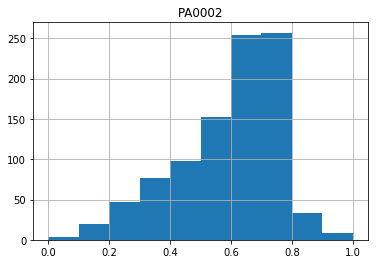

In [6]:
normalized_data.hist(column='PA0002')

In [7]:
simulated_data.head(10)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
GSM199982.CEL,0.646,0.706,0.399,0.642,0.419,0.292,0.424,0.468,0.454,0.496,...,0.535,0.604,0.489,0.526,0.263,0.378,0.444,0.572,0.655,E-GEOD-8083
GSM199983.CEL,0.648,0.706,0.402,0.644,0.424,0.294,0.417,0.469,0.451,0.495,...,0.540,0.611,0.494,0.529,0.266,0.382,0.448,0.577,0.657,E-GEOD-8083
GSM199984.CEL,0.598,0.670,0.433,0.638,0.443,0.364,0.367,0.447,0.433,0.506,...,0.529,0.601,0.487,0.499,0.330,0.392,0.494,0.587,0.636,E-GEOD-8083
GSM199985.CEL,0.614,0.695,0.455,0.667,0.445,0.357,0.364,0.465,0.458,0.481,...,0.542,0.606,0.498,0.509,0.304,0.400,0.500,0.595,0.645,E-GEOD-8083
GSM199986.CEL,0.606,0.680,0.444,0.652,0.446,0.362,0.364,0.456,0.444,0.494,...,0.536,0.605,0.494,0.504,0.318,0.398,0.498,0.593,0.642,E-GEOD-8083
GSM234928.CEL,0.748,0.660,0.375,0.705,0.471,0.316,0.608,0.555,0.534,0.044,...,0.346,0.523,0.460,0.647,0.062,0.410,0.416,0.673,0.778,E-GEOD-9255
GSM234929.CEL,0.327,0.334,0.183,0.379,0.359,0.478,0.363,0.432,0.389,0.320,...,0.294,0.294,0.387,0.402,0.664,0.782,0.452,0.366,0.345,E-GEOD-9255
GSM242671.CEL,0.466,0.678,0.469,0.777,0.279,0.207,0.606,0.378,0.340,0.523,...,0.317,0.320,0.210,0.096,0.169,0.076,0.224,0.471,0.577,E-GEOD-9592
GSM242676.CEL,0.668,0.842,0.603,0.846,0.558,0.403,0.228,0.518,0.570,0.393,...,0.448,0.433,0.425,0.346,0.098,0.090,0.434,0.693,0.711,E-GEOD-9592
GSM242677.CEL,0.460,0.704,0.475,0.786,0.249,0.194,0.609,0.330,0.302,0.559,...,0.296,0.329,0.182,0.075,0.163,0.091,0.166,0.436,0.561,E-GEOD-9592


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e70c2fd30>]],
      dtype=object)

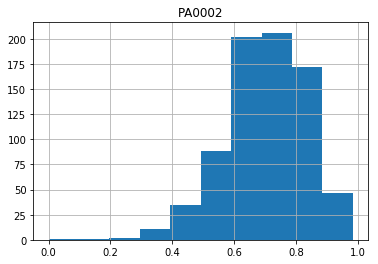

In [8]:
simulated_data.hist(column='PA0002')

## Oxygen gradient experiment

**Question:** Is the gene expression pattern/profile of the PA1683 gene consistent between the input and the simulated data?  (The magnitude of the activity may be different but the trend should be the same)

In [9]:
# Get experiment id
experiment_id = 'E-GEOD-52445'

In [10]:
# Get simulated samples associated with experiment_id
selected_simulated_data = simulated_data[simulated_data['experiment_id'] == experiment_id]

# Get sample ids associated with experiment_id
selected_sample_ids = list(selected_simulated_data.index)

selected_simulated_data.head(5)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
GSM1267086_HZI1981_G1a.CEL,0.546,0.648,0.389,0.636,0.400,0.313,0.443,0.449,0.417,0.562,...,0.543,0.460,0.383,0.388,0.335,0.375,0.470,0.503,0.598,E-GEOD-52445
GSM1267087_HZI1950_Pae_G1a.CEL,0.551,0.700,0.379,0.666,0.356,0.247,0.537,0.458,0.442,0.481,...,0.517,0.471,0.385,0.381,0.272,0.330,0.447,0.492,0.593,E-GEOD-52445
GSM1267088_HZI1951_Pae_G1a.CEL,0.551,0.660,0.393,0.638,0.393,0.311,0.466,0.453,0.435,0.581,...,0.525,0.492,0.416,0.427,0.360,0.432,0.515,0.527,0.607,E-GEOD-52445
GSM1267089_HZI1952_Pae_G1a.CEL,0.550,0.675,0.372,0.645,0.363,0.278,0.493,0.444,0.433,0.529,...,0.515,0.487,0.410,0.423,0.318,0.385,0.488,0.524,0.606,E-GEOD-52445
GSM1267090_HZI1953a_Pae_G1a.CEL,0.583,0.660,0.381,0.668,0.379,0.304,0.451,0.483,0.447,0.542,...,0.540,0.495,0.445,0.469,0.322,0.431,0.532,0.558,0.630,E-GEOD-52445


In [11]:
# Get original samples associated with experiment_id
selected_original_data = normalized_data.loc[selected_sample_ids]

selected_original_data.head(5)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM1267086_HZI1981_G1a.CEL,0.646862,0.679788,0.403342,0.590506,0.336135,0.354079,0.873178,0.550167,0.545020,0.161909,...,0.289186,0.535974,0.557875,0.526033,0.686710,0.192233,0.445449,0.448403,0.696176,0.674890
GSM1267087_HZI1950_Pae_G1a.CEL,0.672238,0.742309,0.333766,0.675540,0.327351,0.188582,0.941649,0.664669,0.504285,0.188626,...,0.224229,0.530254,0.539841,0.570655,0.703041,0.146765,0.375490,0.530460,0.659498,0.693848
GSM1267088_HZI1951_Pae_G1a.CEL,0.606429,0.717016,0.389281,0.692173,0.371449,0.208108,0.894712,0.699663,0.620941,0.168557,...,0.333041,0.487957,0.579132,0.679318,0.784700,0.211256,0.438018,0.702069,0.796113,0.764060
GSM1267089_HZI1952_Pae_G1a.CEL,0.593320,0.720939,0.307024,0.733425,0.391951,0.282023,0.930575,0.718343,0.599914,0.162725,...,0.380829,0.443571,0.520383,0.587204,0.799703,0.151036,0.329585,0.632248,0.774848,0.772045
GSM1267090_HZI1953a_Pae_G1a.CEL,0.559336,0.684122,0.313812,0.621583,0.431680,0.276904,0.776492,0.661612,0.574422,0.154941,...,0.471574,0.492006,0.511409,0.630100,0.734772,0.187909,0.411634,0.595385,0.788193,0.736931


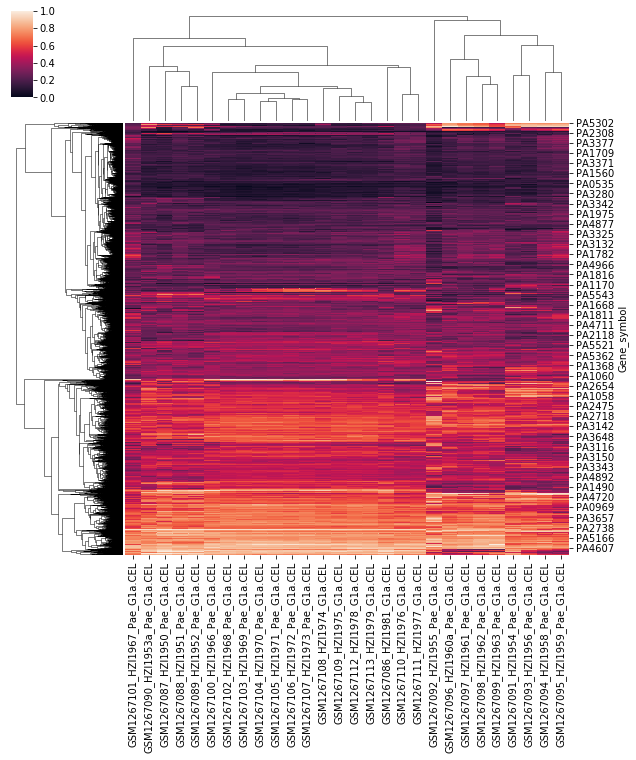

In [12]:
# Plot original data
sns.clustermap(selected_original_data.T)

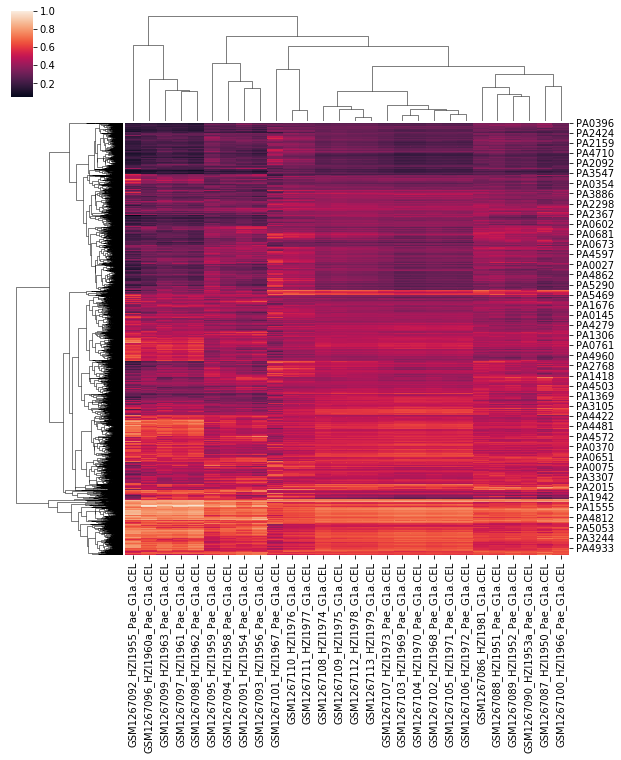

In [13]:
# Plot simulated
selected_simulated_data = selected_simulated_data.drop(columns=['experiment_id'])
sns.clustermap(selected_simulated_data.T)

## Two different conditions

In [14]:
# Get experiment id
#experiment_id = 'E-GEOD-43641'
#experiment_id = 'E-GEOD-51409'
#experiment_id = 'E-GEOD-49759'
experiment_id = 'E-GEOD-30967'

In [15]:
# Get simulated samples associated with experiment_id
selected_simulated_data = simulated_data[simulated_data['experiment_id'] == experiment_id]

# Get sample ids associated with experiment_id
selected_sample_ids = list(selected_simulated_data.index)

selected_simulated_data.head(5)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
GSM767700.CEL,0.505,0.647,0.332,0.596,0.328,0.344,0.381,0.438,0.414,0.458,...,0.527,0.436,0.461,0.496,0.348,0.457,0.462,0.578,0.656,E-GEOD-30967
GSM767701.CEL,0.517,0.651,0.329,0.600,0.319,0.329,0.347,0.446,0.423,0.465,...,0.521,0.439,0.474,0.506,0.353,0.476,0.473,0.582,0.659,E-GEOD-30967
GSM767702.CEL,0.487,0.608,0.310,0.564,0.300,0.315,0.371,0.418,0.397,0.455,...,0.505,0.425,0.464,0.517,0.353,0.463,0.441,0.557,0.638,E-GEOD-30967
GSM767703.CEL,0.665,0.790,0.407,0.674,0.478,0.510,0.363,0.406,0.438,0.430,...,0.628,0.613,0.492,0.490,0.386,0.482,0.575,0.645,0.656,E-GEOD-30967
GSM767704.CEL,0.667,0.791,0.411,0.674,0.488,0.516,0.357,0.405,0.441,0.434,...,0.627,0.614,0.494,0.488,0.380,0.478,0.575,0.646,0.656,E-GEOD-30967


In [16]:
# Get original samples associated with experiment_id
selected_original_data = normalized_data.loc[selected_sample_ids]

selected_original_data.head(10)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM767700.CEL,0.480877,0.573099,0.284267,0.421697,0.323211,0.362143,0.648218,0.332186,0.159017,0.167176,...,0.364856,0.487406,0.513247,0.319551,0.569904,0.165311,0.395879,0.469684,0.561713,0.671884
GSM767701.CEL,0.502423,0.564154,0.257679,0.393500,0.317711,0.312040,0.610570,0.340138,0.156616,0.162095,...,0.370335,0.468070,0.549470,0.275715,0.582973,0.205312,0.411136,0.503978,0.572684,0.682131
GSM767702.CEL,0.463626,0.512271,0.263565,0.388080,0.363273,0.386885,0.597942,0.368408,0.137536,0.169904,...,0.347452,0.497408,0.494056,0.313791,0.507676,0.162626,0.380288,0.473429,0.550772,0.672922
GSM767703.CEL,0.492842,0.628751,0.180435,0.311207,0.402911,0.315948,0.461743,0.265283,0.233455,0.164258,...,0.407957,0.551416,0.612808,0.360528,0.575186,0.135926,0.462727,0.368229,0.411879,0.629325
GSM767704.CEL,0.490781,0.600183,0.160295,0.300644,0.392372,0.353231,0.465937,0.261578,0.210465,0.178472,...,0.446873,0.559573,0.602767,0.358310,0.576923,0.131362,0.459550,0.365816,0.395792,0.620504
GSM767705.CEL,0.511984,0.654322,0.168878,0.389031,0.416008,0.311485,0.470922,0.295170,0.189969,0.170165,...,0.428677,0.542770,0.594056,0.375043,0.572682,0.126494,0.475404,0.385646,0.417996,0.614675


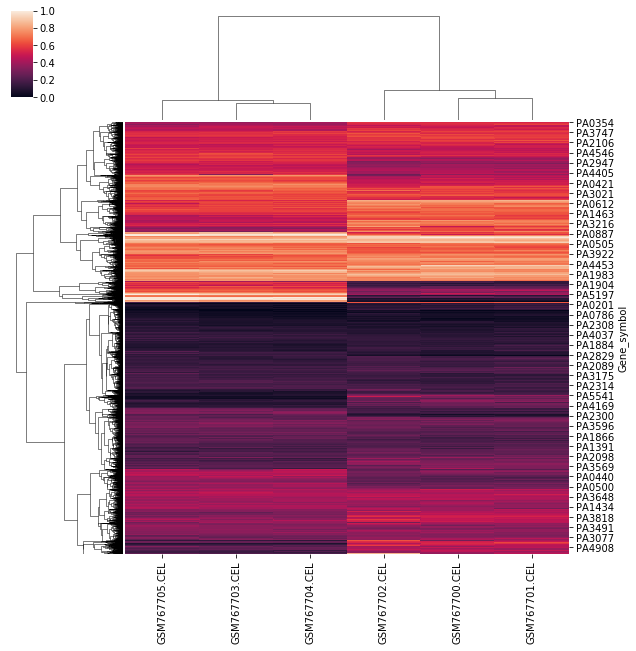

In [17]:
# Plot original data
sns.clustermap(selected_original_data.T)

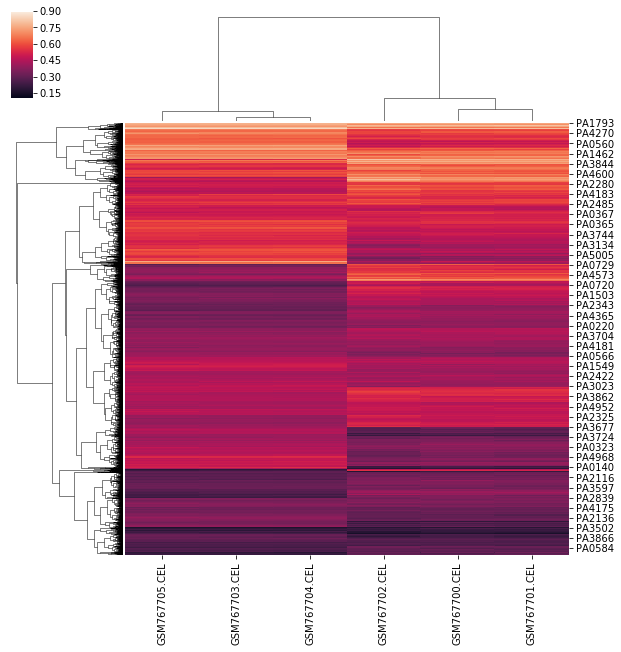

In [18]:
# Plot simulated
selected_simulated_data = selected_simulated_data.drop(columns=['experiment_id'])
sns.clustermap(selected_simulated_data.T)

## Output selected gene expression data

We will use this to put into R script to identify differentially expressed genes (DEGs)

In [19]:
selected_simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "selected_simulated_data.txt")

selected_original_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "selected_original_data.txt")

selected_simulated_data.to_csv(
        selected_simulated_data_file, float_format='%.3f', sep='\t')

selected_original_data.to_csv(
        selected_original_data_file, float_format='%.3f', sep='\t')

## Find differentially expressed genes

In [20]:
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

In [22]:
%%R
source("/home/alexandra/Documents/Repos/Batch_effects_simulation/scripts/functions/DE_analysis.R")
experiment_id = 'E-GEOD-30967'
find_DEGs("metadata_deg_phosphate", experiment_id)
#find_DEGs("metadata_deg_temp")

[1] 4820
[1] 3669


## Visualize gene expression data using DEGs

In [23]:
# Import list of DEGs
DEG_sim_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "sign_DEG_sim_"+experiment_id+".txt")

DEG_original_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "sign_DEG_original_"+experiment_id+".txt")

In [24]:
# Read data
DEG_sim_data = pd.read_table(
    DEG_sim_file,
    header=0,
    sep='\t',
    index_col=0)

DEG_original_data = pd.read_table(
    DEG_original_file,
    header=0,
    sep='\t',
    index_col=0)

DEG_sim_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
Gene,,,,,,
PA5403,-0.350333,0.531500,-56.475372,1.492597e-12,4.371884e-09,19.471438
PA4291,-0.337000,0.588167,-56.126898,1.575738e-12,4.371884e-09,19.423928
PA4170,0.376333,0.495500,51.664226,3.254801e-12,6.020297e-09,18.776519
PA3538,-0.391667,0.498833,-49.632619,4.624010e-12,6.414658e-09,18.455778
PA3572,0.326333,0.711167,47.866641,6.348929e-12,6.836871e-09,18.162336


In [25]:
# Get DEG ids
sim_gene_ids = list(DEG_sim_data.index)
original_gene_ids = list(DEG_original_data.index)

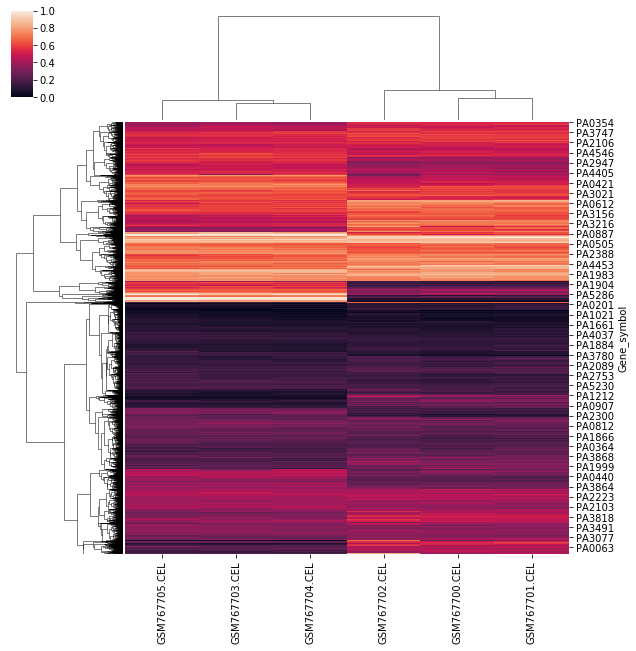

In [26]:
# Plot original data
selected_original_DEG_data = selected_original_data[original_gene_ids]
sns.clustermap(selected_original_DEG_data.T)

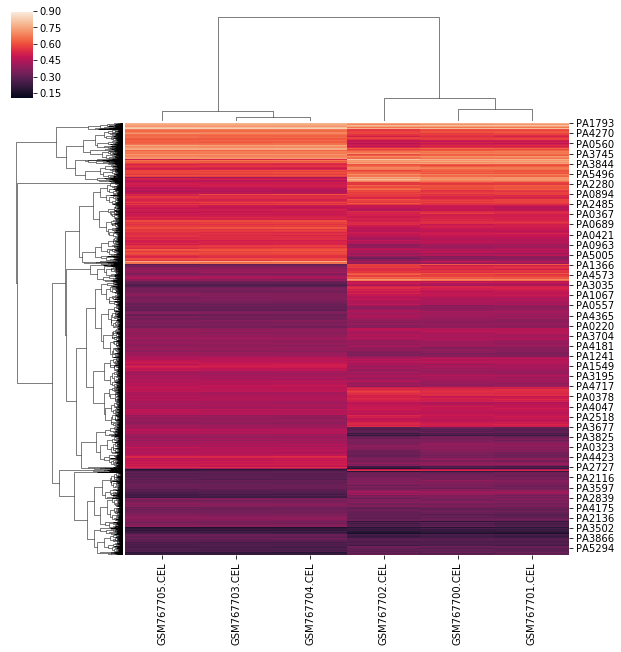

In [27]:
# Plot simulated
#selected_simulated_data = selected_simulated_data.drop(columns=['experiment_id'])
selected_simulated_DEG_data = selected_simulated_data[sim_gene_ids]
sns.clustermap(selected_simulated_DEG_data.T)